File Handling:

news.tsv: We will use the news metadata, including titles and categories, for training and testing the RNN model.

behaviors.tsv: This file contains user interaction data, but for this classification task, we will primarily focus on news.tsv.

relation_embedding.vec and entity_embedding.vec can be ignored for now


Fangzhao Wu, Ying Qiao, Jiun-Hung Chen, Chuhan Wu, Tao Qi, Jianxun Lian, Danyang Liu, Xing Xie, Jianfeng Gao, Winnie Wu and Ming Zhou. MIND: A Large-scale Dataset for News Recommendation. ACL 2020.
https://msnews.github.io/


https://www.kaggle.com/datasets/rmisra/news-category-dataset


In [1]:
#!pip install pandas matplotlib seaborn scikit-learn textblob numpy pyspark tensorflow
#!pip install elephas pyspark tensorflow keras
#!pip install elephas
#!pip install pyarrow
#!pip install --upgrade pip
#!pip install --upgrade tensorflow
#!pip install tensorflow
#!pip install protobuf==3.20.3

# **Import librires and data**


In [2]:
# Data handling and manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Feature Extraction
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# TensorFlow / Keras for Model Building
import tensorflow as tf # I had to downgrade my tf version to get elephas to work
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical

# Apache Spark for Distributed Processing
from pyspark import RDD
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, concat_ws, when
from pyspark.sql.types import ArrayType, IntegerType
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Elephas for Spark + Keras Integration
from elephas.spark_model import SparkModel
from elephas.utils.rdd_utils import to_simple_rdd

# TextBlob for Sentiment Analysis
from textblob import TextBlob

# PyArrow for Optimized Data Exchange
import pyarrow

# Ensure visualizations are inline
%matplotlib inline



In [3]:
# Define paths to the MINDlarge datasets (train, dev, and test)
train_path = 'MINDlarge_train/news.tsv'
dev_path = 'MINDlarge_dev/news.tsv'
test_path = 'MINDlarge_test/news.tsv'

# Load the data into separate Pandas DataFrames
train_df = pd.read_csv(train_path, sep='\t', header=None)
dev_df = pd.read_csv(dev_path, sep='\t', header=None)
test_df = pd.read_csv(test_path, sep='\t', header=None)

# Assign column names based on the data structure
columns = ['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'entity', 'abstract_entity']
train_df.columns = columns
dev_df.columns = columns
test_df.columns = columns

# Display the first few rows of each DataFrame
print("Train DataFrame Head:")
print(train_df.head())

print("\nDev DataFrame Head:")
print(dev_df.head())

print("\nTest DataFrame Head:")
print(test_df.head())

(Wu et al., 2020)

Train DataFrame Head:
  news_id   category               subcategory  \
0  N88753  lifestyle           lifestyleroyals   
1  N45436       news  newsscienceandtechnology   
2  N23144     health                weightloss   
3  N86255     health                   medical   
4  N93187       news                 newsworld   

                                               title  \
0  The Brands Queen Elizabeth, Prince Charles, an...   
1    Walmart Slashes Prices on Last-Generation iPads   
2                      50 Worst Habits For Belly Fat   
3  Dispose of unwanted prescription drugs during ...   
4  The Cost of Trump's Aid Freeze in the Trenches...   

                                            abstract  \
0  Shop the notebooks, jackets, and more that the...   
1  Apple's new iPad releases bring big deals on l...   
2  These seemingly harmless habits are holding yo...   
3                                                NaN   
4  Lt. Ivan Molchanets peeked over a parapet of s...   

   

Total entries across train, dev, and test datasets: 294509
Train Data - Number of Categories: 18, Subcategories: 285
Dev Data - Number of Categories: 17, Subcategories: 269
Test Data - Number of Categories: 18, Subcategories: 290


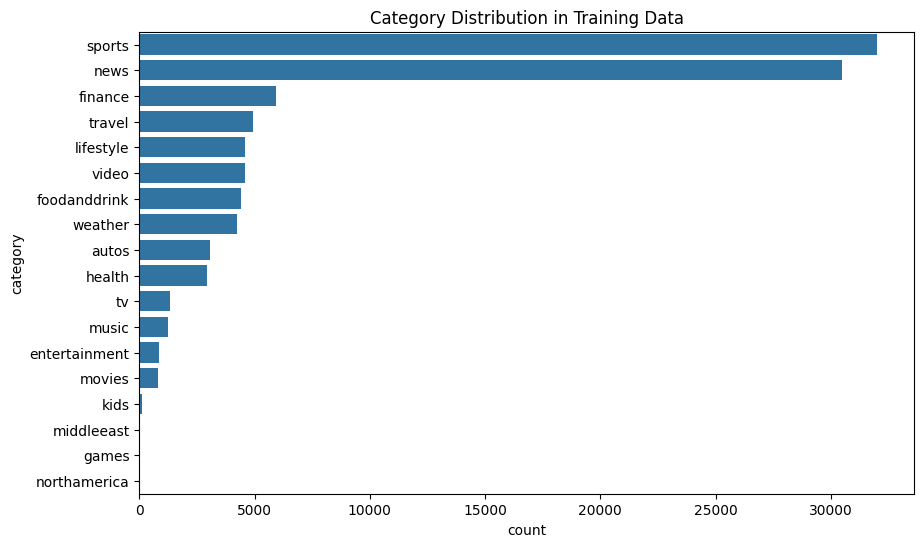

In [4]:
# Count total number of entries across all three datasets
total_entries = len(train_df) + len(dev_df) + len(test_df)
print(f'Total entries across train, dev, and test datasets: {total_entries}')

# Display basic stats for categories and subcategories in each dataset
train_categories = train_df['category'].nunique()
train_subcategories = train_df['subcategory'].nunique()

print(f'Train Data - Number of Categories: {train_categories}, Subcategories: {train_subcategories}')
print(f'Dev Data - Number of Categories: {dev_df["category"].nunique()}, Subcategories: {dev_df["subcategory"].nunique()}')
print(f'Test Data - Number of Categories: {test_df["category"].nunique()}, Subcategories: {test_df["subcategory"].nunique()}')

# Plotting category distribution in train data
plt.figure(figsize=(10, 6))
sns.countplot(y='category', data=train_df, order=train_df['category'].value_counts().index)
plt.title('Category Distribution in Training Data')
plt.show()


As can be seen in the data above, there are just under 300 000 entries. therefore I will combine another df to reach the minimum goal of 500 000 entries


In [5]:
# Loading the new dataset
new_dataset_path = 'News Category/News_Category_Dataset_v3.json'
new_df = pd.read_json(new_dataset_path, lines=True)

# Display the head of the new dataset
print("New JSON DataFrame Head:")
print(new_df.head())
new_df.shape

New JSON DataFrame Head:
                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2

(209527, 6)

This data has over 200 000. combined we will reach the 500 000 goal.

Now that all the df's have been imported and labeled. I will make sure the columns match


# **Data cleaning and combining**

In [6]:
# Function to create a table
def display_first_5(df, df_name):
    print(f"\n{df_name} Dataset (First 5 Rows):")
    display(df.head())

# Display each dataframe in a neat table format
display_first_5(train_df, "Train")
display_first_5(dev_df, "Dev")
display_first_5(test_df, "Test")
display_first_5(new_df, "New")



Train Dataset (First 5 Rows):


,news_id,category,subcategory,title,abstract,url,entity,abstract_entity
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N45436,news,newsscienceandtechnology,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on l...,https://assets.msn.com/labs/mind/AABmf2I.html,"[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ...","[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ..."
2,N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
3,N86255,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
4,N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."



Dev Dataset (First 5 Rows):


,news_id,category,subcategory,title,abstract,url,entity,abstract_entity
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N86255,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
3,N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
4,N75236,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."



Test Dataset (First 5 Rows):


,news_id,category,subcategory,title,abstract,url,entity,abstract_entity
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N45436,news,newsscienceandtechnology,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on l...,https://assets.msn.com/labs/mind/AABmf2I.html,"[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ...","[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ..."
2,N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
3,N86255,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
4,N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."



New Dataset (First 5 Rows):


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


First i will split the new df into train test and dev, in the same proportions as the other dfs.

Then i will match the necessary columns and drop all uncessary columns

Then I will make sure the categories match, because i can see that the formatting is different 

In [7]:
# Calculate the total number of entries across all MIND datasets
total_mind_records = len(train_df) + len(dev_df) + len(test_df)

# Calculate proportions for each dataset
train_proportion = len(train_df) / total_mind_records
dev_proportion = len(dev_df) / total_mind_records
test_proportion = len(test_df) / total_mind_records

# Display proportions
print(f"Train Proportion: {train_proportion:.2f}, Dev Proportion: {dev_proportion:.2f}, Test Proportion: {test_proportion:.2f}")


Train Proportion: 0.34, Dev Proportion: 0.24, Test Proportion: 0.41


In [8]:
# Split the new dataset into train, dev, and test sets using the same proportions
train_new_df, temp_new_df = train_test_split(new_df, test_size=(dev_proportion + test_proportion), random_state=42)
dev_new_df, test_new_df = train_test_split(temp_new_df, test_size=test_proportion / (dev_proportion + test_proportion), random_state=42)

# Display the number of rows in each split of the new dataset
print(f'New Training Set: {len(train_new_df)} rows')
print(f'New Validation Set: {len(dev_new_df)} rows')
print(f'New Test Set: {len(test_new_df)} rows')

New Training Set: 72230 rows
New Validation Set: 51240 rows
New Test Set: 86057 rows


In [9]:
# Function to match columns of the new dataset with the old dataset format
def match_columns(df):
    df['news_id'] = ['JSON_' + str(i) for i in range(len(df))]  # Create a unique news_id
    df['title'] = df['headline']  # Rename 'headline' to 'title'
    df['abstract'] = df['short_description'].fillna('')  # Rename 'short_description' to 'abstract'
    df['subcategory'] = 'general'  # Placeholder for 'subcategory'
    df['url'] = df['link']  # Rename 'link' to 'url'
    df['entity'] = 'NA'  # Placeholder for 'entity'
    df['abstract_entity'] = 'NA'  # Placeholder for 'abstract_entity'
    
    # Reorder columns to match the MIND dataset
    return df[['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'entity', 'abstract_entity']]

# Apply the function to all new datasets (train, dev, test)
train_new_df = match_columns(train_new_df)
dev_new_df = match_columns(dev_new_df)
test_new_df = match_columns(test_new_df)


In [10]:
# Function to print the column names and first 5 rows of a dataframe
def display_first_5(df, df_name):
    print(f"\n{df_name} Dataset (First 5 Rows):")
    print(df.head())

# Display column names and first 5 rows for each of the new dataframes (train, dev, test)
display_first_5(train_new_df, "New Train")
display_first_5(dev_new_df, "New Dev")
display_first_5(test_new_df, "New Test")


New Train Dataset (First 5 Rows):
       news_id      category subcategory  \
53145   JSON_0         STYLE     general   
2626    JSON_1     U.S. NEWS     general   
44934   JSON_2      POLITICS     general   
11083   JSON_3         MEDIA     general   
175074  JSON_4  BLACK VOICES     general   

                                                    title  \
53145   Taylor Swift Goes Back To Her True Self In A B...   
2626    Teenage Daughter Of Author Michael Lewis, Phot...   
44934   Bernie Sanders Slams Trump's Budget Chief Pick...   
11083   In Historic Move, Chicago Tribune Staffers Pre...   
175074       Black History Month Photo Of The Day (PHOTO)   

                                                 abstract  \
53145          Lightning strikes every time she moves. ⚡️   
2626    Dixie Lewis, 19, and her boyfriend Ross Schult...   
44934   "Your recommendation is that we should deny 2½...   
11083   The paper's corporate overlords at Tronc have ...   
175074  A picture is certain

In [11]:
# Function to display unique categories and subcategories for a dataframe
def display_unique_categories_and_subcategories(df, df_name):
    print(f"\n{df_name} Dataset Unique Categories:")
    print(df['category'].unique())
    print(f"\n{df_name} Dataset Unique Subcategories:")
    print(df['subcategory'].unique())

# Display unique categories and subcategories for each of the 6 datasets
display_unique_categories_and_subcategories(train_df, "Train")
display_unique_categories_and_subcategories(dev_df, "Dev")
display_unique_categories_and_subcategories(test_df, "Test")

display_unique_categories_and_subcategories(train_new_df, "New Train")
display_unique_categories_and_subcategories(dev_new_df, "New Dev")
display_unique_categories_and_subcategories(test_new_df, "New Test")


Train Dataset Unique Categories:
['lifestyle' 'news' 'health' 'sports' 'weather' 'entertainment'
 'foodanddrink' 'autos' 'travel' 'video' 'finance' 'tv' 'movies' 'music'
 'kids' 'middleeast' 'games' 'northamerica']

Train Dataset Unique Subcategories:
['lifestyleroyals' 'newsscienceandtechnology' 'weightloss' 'medical'
 'newsworld' 'voices' 'cardio' 'football_nfl' 'weathertopstories' 'gaming'
 'recipes' 'lifestylelovesex' 'nutrition' 'autosenthusiasts' 'autossports'
 'wellness' 'health-news' 'celebrity' 'travelarticle' 'autossuvs'
 'newspolitics' 'more_sports' 'traveltripideas' 'animals' 'autosnews'
 'newsbusiness' 'golf' 'newstrends' 'lifestylepetsanimals'
 'finance-insurance' 'football_ncaa' 'lifestylebuzz' 'mma' 'fitness'
 'newsus' 'tv-gallery' 'tvnews' 'lifestylehoroscope' 'basketball_nba'
 'news' 'shop-all' 'newsphotos' 'lifestylemindandsoul' 'travelnews'
 'basketball_ncaa' 'finance-real-estate' 'quickandeasy' 'tv-celebrity'
 'financenews' 'lifestyleparenting' 'movies-gallery' 'r

due to the new df not having sub categories, i have decided to remove this column. While doing this i decided to clean the rest of the uncessary columns

I will also be dropping : news_id	subcategory	abstract	url	entity	abstract_entity

This leaves me with only the category, title and abstract 

In [12]:
# Function to drop unnecessary columns from a dataframe
def clean_dataframe(df):
    return df.drop(columns=['news_id', 'subcategory', 'url', 'entity', 'abstract_entity'])

# Apply the cleaning to the train, dev, and test datasets (MIND and new)
cleaned_train_df = clean_dataframe(train_df)
cleaned_dev_df = clean_dataframe(dev_df)
cleaned_test_df = clean_dataframe(test_df)

cleaned_train_new_df = clean_dataframe(train_new_df)
cleaned_dev_new_df = clean_dataframe(dev_new_df)
cleaned_test_new_df = clean_dataframe(test_new_df)

# Display the first few rows of each cleaned dataframe to verify
print("Cleaned Train Dataset:")
print(cleaned_train_df.head())

print("\nCleaned Dev Dataset:")
print(cleaned_dev_df.head())

print("\nCleaned Test Dataset:")
print(cleaned_test_df.head())

print("\nCleaned New Train Dataset:")
print(cleaned_train_new_df.head())

print("\nCleaned New Dev Dataset:")
print(cleaned_dev_new_df.head())

print("\nCleaned New Test Dataset:")
print(cleaned_test_new_df.head())

Cleaned Train Dataset:
    category                                              title  \
0  lifestyle  The Brands Queen Elizabeth, Prince Charles, an...   
1       news    Walmart Slashes Prices on Last-Generation iPads   
2     health                      50 Worst Habits For Belly Fat   
3     health  Dispose of unwanted prescription drugs during ...   
4       news  The Cost of Trump's Aid Freeze in the Trenches...   

                                            abstract  
0  Shop the notebooks, jackets, and more that the...  
1  Apple's new iPad releases bring big deals on l...  
2  These seemingly harmless habits are holding yo...  
3                                                NaN  
4  Lt. Ivan Molchanets peeked over a parapet of s...  

Cleaned Dev Dataset:
    category                                              title  \
0  lifestyle  The Brands Queen Elizabeth, Prince Charles, an...   
1     health                      50 Worst Habits For Belly Fat   
2     health  Dispose

No I will fix up the category formatting 

In [13]:
# Function to clean the category column by lowercasing and replacing special characters
def clean_category(df):
    df['category'] = df['category'].str.lower().str.replace('&', 'and').str.replace('[^a-zA-Z\s]', '').str.strip()
    return df

# Apply the function to the new datasets (train, dev, test)
cleaned_train_new_df = clean_category(train_new_df)
cleaned_dev_new_df = clean_category(dev_new_df)
cleaned_test_new_df = clean_category(test_new_df)

# Display the unique categories after cleaning
print("New Train Dataset Unique Categories After Cleaning:")
print(cleaned_train_new_df['category'].unique())

print("\nNew Dev Dataset Unique Categories After Cleaning:")
print(cleaned_dev_new_df['category'].unique())

print("\nNew Test Dataset Unique Categories After Cleaning:")
print(cleaned_test_new_df['category'].unique())


#OpenAi (2024)
#GithubCoPiolet (2024)

New Train Dataset Unique Categories After Cleaning:
['style' 'u.s. news' 'politics' 'media' 'black voices' 'healthy living'
 'arts' 'entertainment' 'environment' 'parenting' 'worldpost'
 'food and drink' 'women' 'science' 'world news' 'queer voices' 'wellness'
 'comedy' 'business' 'the worldpost' 'good news' 'parents' 'travel'
 'green' 'home and living' 'taste' 'style and beauty' 'money' 'divorce'
 'tech' 'weddings' 'crime' 'sports' 'education' 'arts and culture' 'fifty'
 'college' 'weird news' 'culture and arts' 'impact' 'religion'
 'latino voices']

New Dev Dataset Unique Categories After Cleaning:
['style and beauty' 'arts and culture' 'politics' 'wellness' 'business'
 'food and drink' 'entertainment' 'travel' 'parents' 'green'
 'home and living' 'religion' 'the worldpost' 'style' 'parenting'
 'queer voices' 'women' 'college' 'black voices' 'sports' 'media' 'taste'
 'fifty' 'u.s. news' 'divorce' 'world news' 'healthy living' 'comedy'
 'impact' 'science' 'crime' 'weird news' 'wedding

In [14]:
# Display all unique values from the 'category' column for each DataFrame
print("\nUnique categories in Cleaned Train Dataset:")
print(cleaned_train_df['category'].unique())

print("\nUnique categories in Cleaned Dev Dataset:")
print(cleaned_dev_df['category'].unique())

print("\nUnique categories in Cleaned Test Dataset:")
print(cleaned_test_df['category'].unique())

print("\nUnique categories in Cleaned New Train Dataset:")
print(cleaned_train_new_df['category'].unique())

print("\nUnique categories in Cleaned New Dev Dataset:")
print(cleaned_dev_new_df['category'].unique())

print("\nUnique categories in Cleaned New Test Dataset:")
print(cleaned_test_new_df['category'].unique())


Unique categories in Cleaned Train Dataset:
['lifestyle' 'news' 'health' 'sports' 'weather' 'entertainment'
 'foodanddrink' 'autos' 'travel' 'video' 'finance' 'tv' 'movies' 'music'
 'kids' 'middleeast' 'games' 'northamerica']

Unique categories in Cleaned Dev Dataset:
['lifestyle' 'health' 'news' 'sports' 'weather' 'entertainment'
 'foodanddrink' 'autos' 'travel' 'video' 'tv' 'finance' 'movies' 'music'
 'kids' 'middleeast' 'games']

Unique categories in Cleaned Test Dataset:
['lifestyle' 'news' 'health' 'sports' 'weather' 'entertainment'
 'foodanddrink' 'autos' 'travel' 'video' 'finance' 'tv' 'movies' 'music'
 'kids' 'middleeast' 'games' 'northamerica']

Unique categories in Cleaned New Train Dataset:
['style' 'u.s. news' 'politics' 'media' 'black voices' 'healthy living'
 'arts' 'entertainment' 'environment' 'parenting' 'worldpost'
 'food and drink' 'women' 'science' 'world news' 'queer voices' 'wellness'
 'comedy' 'business' 'the worldpost' 'good news' 'parents' 'travel'
 'green' 'h

Now that the data in each df has been cleaned. it is time to merge the datasets to create one with over 500 000 entries

In [15]:

# Concatenate the cleaned DataFrames for train, dev, and test separately
combined_train_df = pd.concat([cleaned_train_df, cleaned_train_new_df], ignore_index=True)
combined_dev_df = pd.concat([cleaned_dev_df, cleaned_dev_new_df], ignore_index=True)
combined_test_df = pd.concat([cleaned_test_df, cleaned_test_new_df], ignore_index=True)

# Display total entry count for each combined DataFrame
print("\nTotal entries in Combined Train Dataset:", len(combined_train_df))
print("Total entries in Combined Dev Dataset:", len(combined_dev_df))
print("Total entries in Combined Test Dataset:", len(combined_test_df))

# Calculate and print the total number of entries across all three DataFrames
total_entries = len(combined_train_df) + len(combined_dev_df) + len(combined_test_df)
print("\nTotal entries across all Combined Datasets:", total_entries)


# Display the first few rows of each new DataFrame
print("Combined Train DataFrame Head:")
print(combined_train_df.head())

print("\nCombined Dev DataFrame Head:")
print(combined_dev_df.head())

print("\nCombined Test DataFrame Head:")
print(combined_test_df.head())


#OpenAi (2024)
#GithubCoPiolet (2024)


Total entries in Combined Train Dataset: 173757
Total entries in Combined Dev Dataset: 123263
Total entries in Combined Test Dataset: 207016

Total entries across all Combined Datasets: 504036
Combined Train DataFrame Head:
    category                                              title  \
0  lifestyle  The Brands Queen Elizabeth, Prince Charles, an...   
1       news    Walmart Slashes Prices on Last-Generation iPads   
2     health                      50 Worst Habits For Belly Fat   
3     health  Dispose of unwanted prescription drugs during ...   
4       news  The Cost of Trump's Aid Freeze in the Trenches...   

                                            abstract news_id subcategory  url  \
0  Shop the notebooks, jackets, and more that the...     NaN         NaN  NaN   
1  Apple's new iPad releases bring big deals on l...     NaN         NaN  NaN   
2  These seemingly harmless habits are holding yo...     NaN         NaN  NaN   
3                                               

Now that we have merged the two datasets into training, test and dev dataframes, we have over the minimum 500 000 entries

In [16]:
# Function to create a table
def display_first_5(df, df_name):
    print(f"\n{df_name} Dataset (First 5 Rows):")
    display(df.head())

# Display the first 5 rows of each combined DataFrame
display_first_5(combined_train_df, "Combined Train")
display_first_5(combined_dev_df, "Combined Dev")
display_first_5(combined_test_df, "Combined Test")


Combined Train Dataset (First 5 Rows):


,category,title,abstract,news_id,subcategory,url,entity,abstract_entity
0,lifestyle,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",NaN,NaN,NaN,NaN,NaN
1,news,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on l...,NaN,NaN,NaN,NaN,NaN
2,health,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,NaN,NaN,NaN,NaN,NaN
3,health,Dispose of unwanted prescription drugs during ...,NaN,NaN,NaN,NaN,NaN,NaN
4,news,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,NaN,NaN,NaN,NaN,NaN



Combined Dev Dataset (First 5 Rows):


,category,title,abstract,news_id,subcategory,url,entity,abstract_entity
0,lifestyle,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",NaN,NaN,NaN,NaN,NaN
1,health,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,NaN,NaN,NaN,NaN,NaN
2,health,Dispose of unwanted prescription drugs during ...,NaN,NaN,NaN,NaN,NaN,NaN
3,news,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,NaN,NaN,NaN,NaN,NaN
4,health,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",NaN,NaN,NaN,NaN,NaN



Combined Test Dataset (First 5 Rows):


,category,title,abstract,news_id,subcategory,url,entity,abstract_entity
0,lifestyle,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",NaN,NaN,NaN,NaN,NaN
1,news,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on l...,NaN,NaN,NaN,NaN,NaN
2,health,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,NaN,NaN,NaN,NaN,NaN
3,health,Dispose of unwanted prescription drugs during ...,NaN,NaN,NaN,NaN,NaN,NaN
4,news,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,NaN,NaN,NaN,NaN,NaN


I can see that i removed the data from the columns I did not want but the headings are still there. Lets remove them


In [17]:
columns_to_drop = ['news_id', 'subcategory', 'url', 'entity', 'abstract_entity']
combined_train_df = combined_train_df.drop(columns=columns_to_drop)
combined_dev_df = combined_dev_df.drop(columns=columns_to_drop)
combined_test_df = combined_test_df.drop(columns=columns_to_drop)

# Function to create a table
def display_first_5(df, df_name):
    print(f"\n{df_name} Dataset (First 5 Rows):")
    display(df.head())

# Display the first 5 rows of each combined DataFrame
display_first_5(combined_train_df, "Combined Train")
display_first_5(combined_dev_df, "Combined Dev")
display_first_5(combined_test_df, "Combined Test")

#OpenAi (2024)
#GithubCoPiolet (2024)


Combined Train Dataset (First 5 Rows):


,category,title,abstract
0,lifestyle,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
1,news,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on l...
2,health,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...
3,health,Dispose of unwanted prescription drugs during ...,NaN
4,news,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...



Combined Dev Dataset (First 5 Rows):


,category,title,abstract
0,lifestyle,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
1,health,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...
2,health,Dispose of unwanted prescription drugs during ...,NaN
3,news,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...
4,health,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi..."



Combined Test Dataset (First 5 Rows):


,category,title,abstract
0,lifestyle,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
1,news,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on l...
2,health,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...
3,health,Dispose of unwanted prescription drugs during ...,NaN
4,news,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...


Finding missing values


In [18]:
# Check for missing values in each combined DataFrame
def find_missing_values(df, df_name):
    print(f"\nMissing values in {df_name} Dataset:")
    print(df.isnull().sum())

# Find missing values in each combined DataFrame
find_missing_values(combined_train_df, "Combined Train")
find_missing_values(combined_dev_df, "Combined Dev")
find_missing_values(combined_test_df, "Combined Test")


Missing values in Combined Train Dataset:
category       0
title          0
abstract    5415
dtype: int64

Missing values in Combined Dev Dataset:
category       0
title          0
abstract    3623
dtype: int64

Missing values in Combined Test Dataset:
category       0
title          0
abstract    6703
dtype: int64


In [19]:
# Drop rows with missing values
combined_train_df = combined_train_df.dropna()
combined_dev_df = combined_dev_df.dropna()
combined_test_df = combined_test_df.dropna()

# Check for missing values in each combined DataFrame
def find_missing_values(df, df_name):
    print(f"\nMissing values in {df_name} Dataset:")
    print(df.isnull().sum())

# Find missing values in each combined DataFrame
find_missing_values(combined_train_df, "Combined Train")
find_missing_values(combined_dev_df, "Combined Dev")
find_missing_values(combined_test_df, "Combined Test")


Missing values in Combined Train Dataset:
category    0
title       0
abstract    0
dtype: int64

Missing values in Combined Dev Dataset:
category    0
title       0
abstract    0
dtype: int64

Missing values in Combined Test Dataset:
category    0
title       0
abstract    0
dtype: int64


Now the data has been fully cleaned, with no missing vales, only useful column headings and re-formatted so the dfs all match

# **Data Analysis**


Now that the data has been cleaned and combines, we will run some analysis before giving the data to the RNN model

First i will run an analysis to see the percentages of each catorgy's accurance in each df

C:\Users\MAMBL\AppData\Local\Temp\ipykernel_7400\2300976723.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


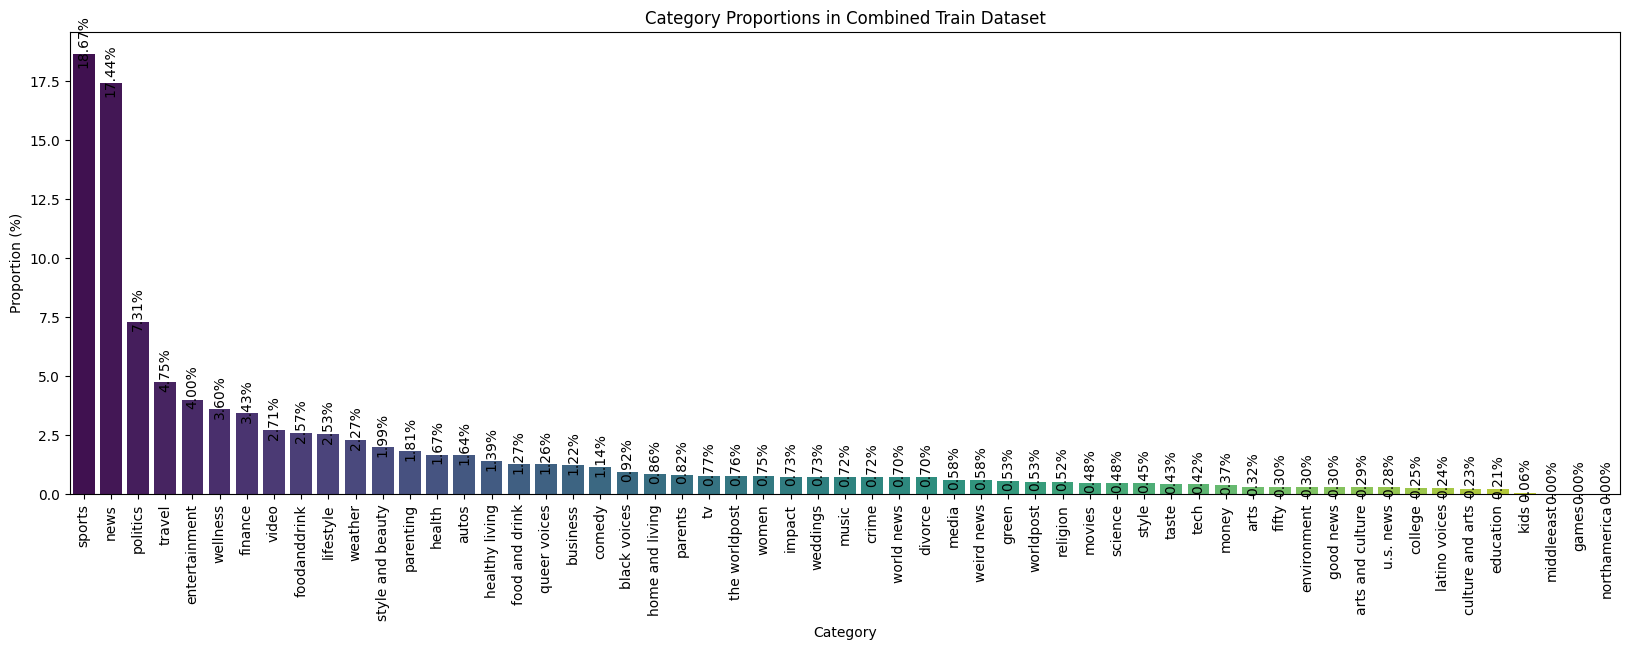

C:\Users\MAMBL\AppData\Local\Temp\ipykernel_7400\2300976723.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


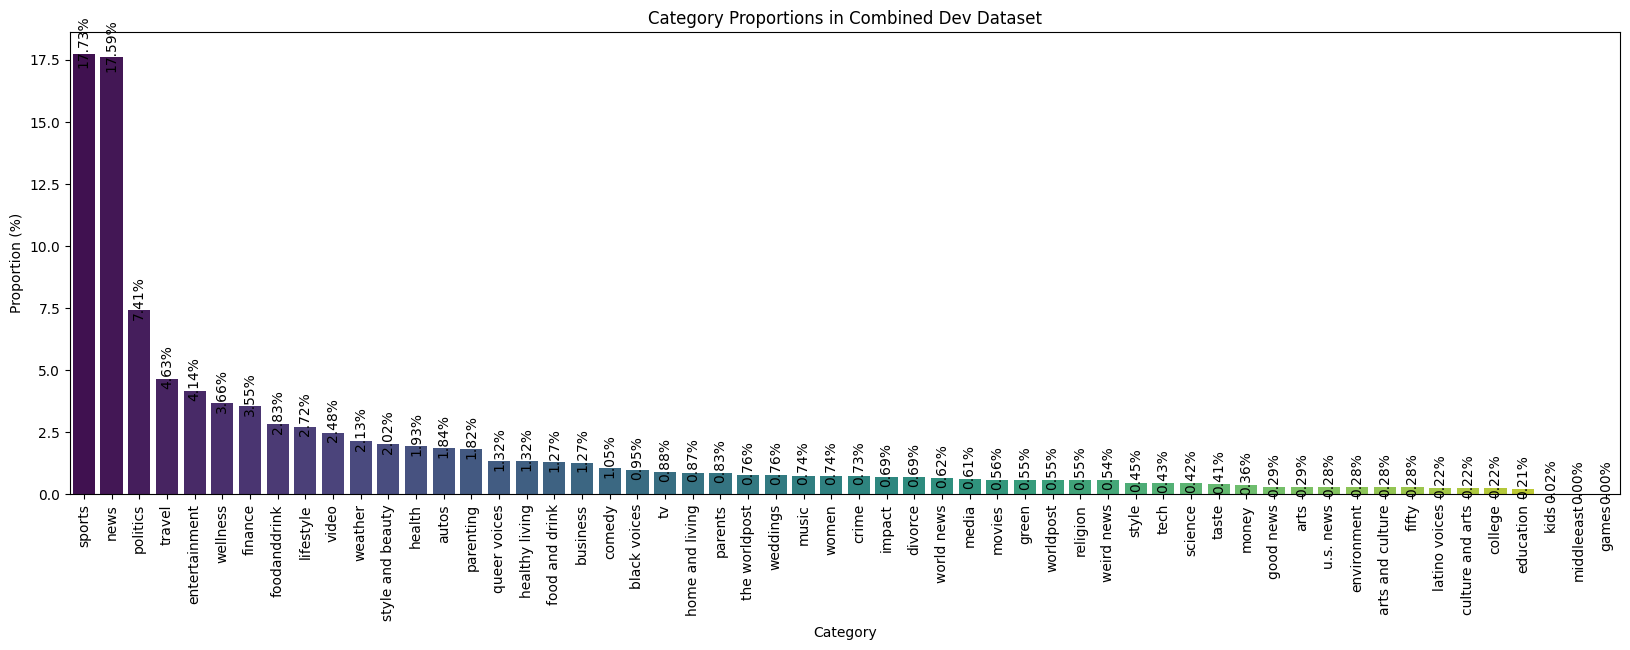

C:\Users\MAMBL\AppData\Local\Temp\ipykernel_7400\2300976723.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


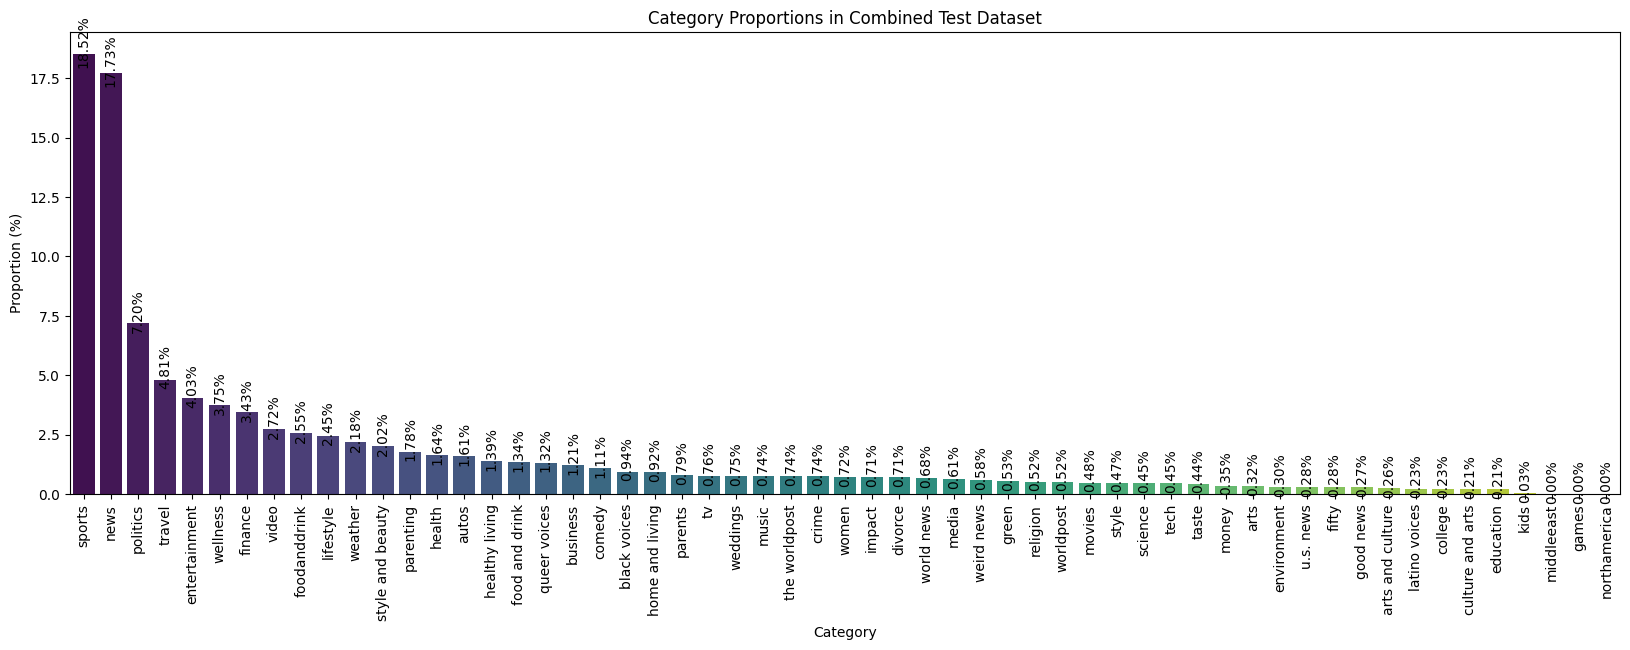

In [20]:
# Function to create a bar chart for category proportions
def plot_category_proportions(df, df_name):
    category_counts = df['category'].value_counts(normalize=True) * 100
    plt.figure(figsize=(20, 6))
    ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
    plt.title(f'Category Proportions in {df_name} Dataset')
    plt.xlabel('Category')
    plt.ylabel('Proportion (%)')
    plt.xticks(rotation=90)  # Set x-axis labels to vertical
    
    # Annotate the bars with the proportion values
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    rotation=90)  # Set annotation text to vertical
    
    plt.show()

# Create bar charts for each combined DataFrame
plot_category_proportions(combined_train_df, "Combined Train")
plot_category_proportions(combined_dev_df, "Combined Dev")
plot_category_proportions(combined_test_df, "Combined Test")

#OpenAi (2024)
#GithubCoPiolet (2024)

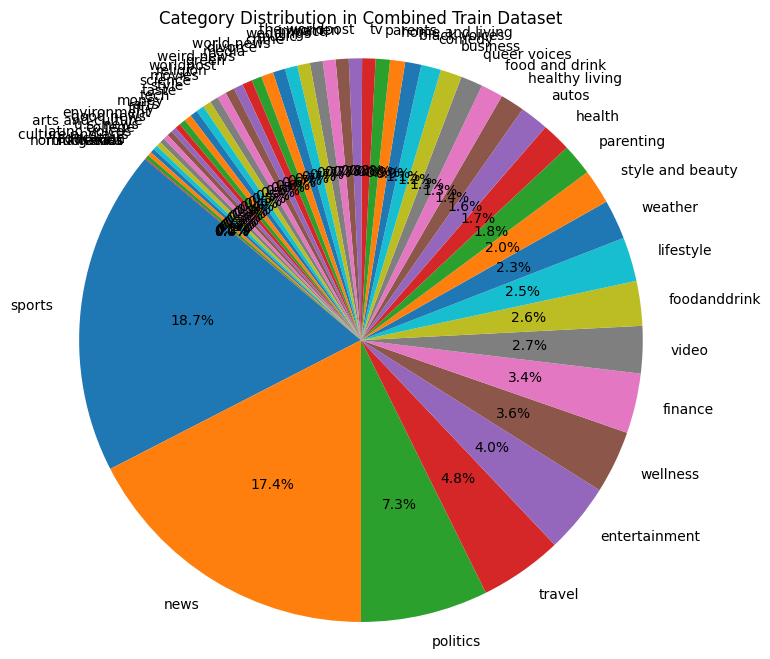

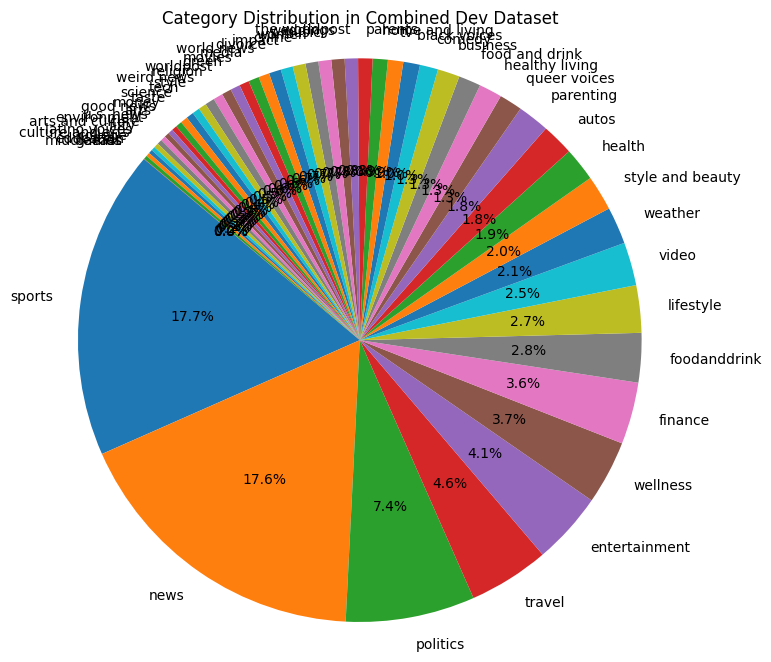

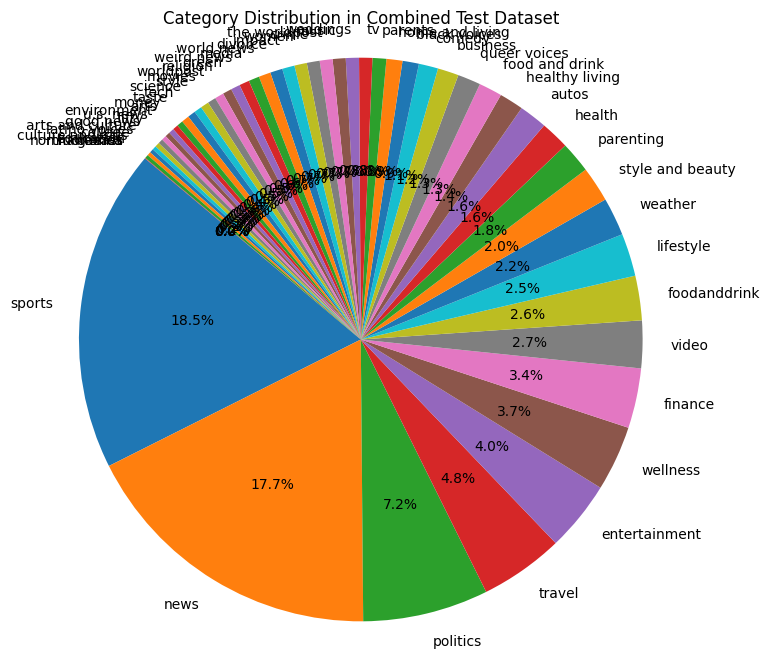

In [21]:
# Function to create a pie chart for class distribution
def plot_class_distribution(df, df_name):
    category_counts = df['category'].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Ensure pie is a circle
    plt.title(f'Category Distribution in {df_name} Dataset')
    plt.show()

# Create pie charts for each dataset
plot_class_distribution(combined_train_df, "Combined Train")
plot_class_distribution(combined_dev_df, "Combined Dev")
plot_class_distribution(combined_test_df, "Combined Test")

#OpenAi (2024)
#GithubCoPiolet (2024)

As can be seen from the above graphs, the proportion of each category is relatively consistent between all the dataframes. We can see that sport and news have a disproportioneatly high percentage. I might have to address this later with over/under sampling to improve accuracy

Next, I will take a look at text length distribution in the title and abstracts


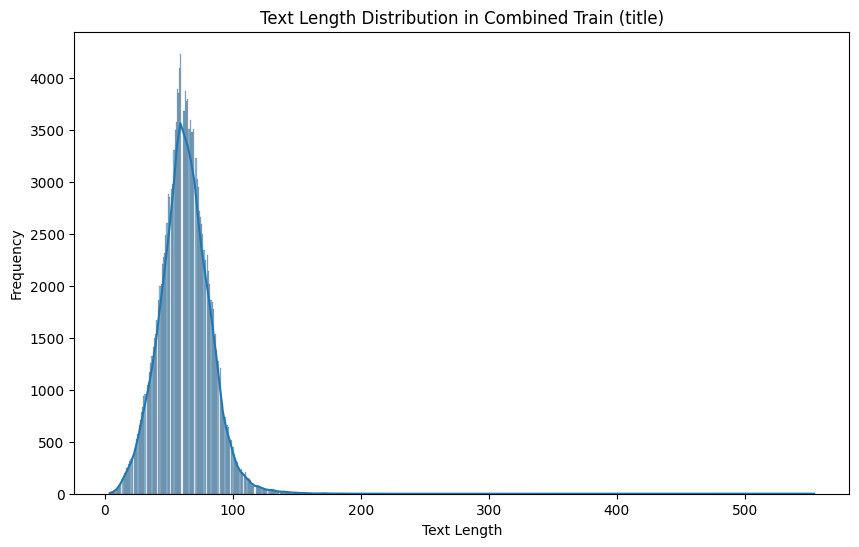

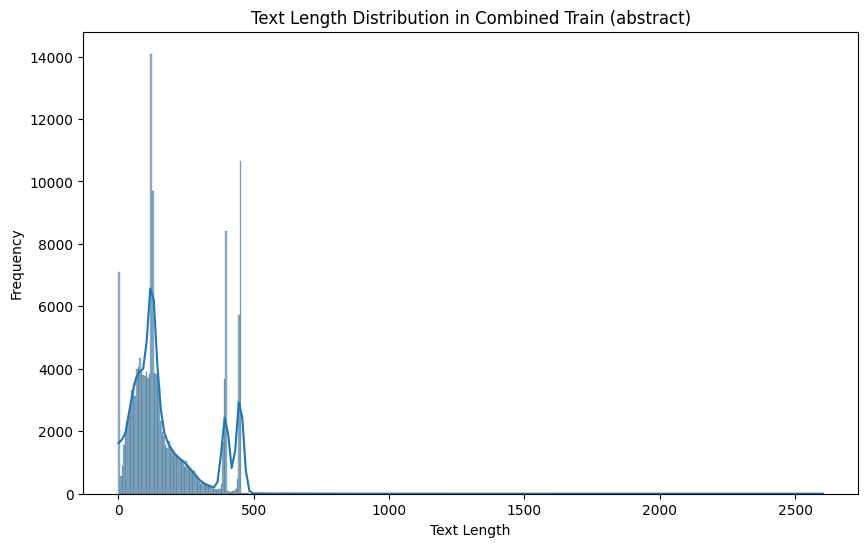

In [22]:
# Function to calculate and plot the text length distribution
def plot_text_length_distribution(df, text_column, df_name):
    df['text_length'] = df[text_column].apply(len)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['text_length'], kde=True)
    plt.title(f'Text Length Distribution in {df_name} ({text_column})')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.show()

# Plot text length distribution for the 'title' and 'abstract' columns
plot_text_length_distribution(combined_train_df, 'title', 'Combined Train')
plot_text_length_distribution(combined_train_df, 'abstract', 'Combined Train')

#OpenAi (2024)
#GithubCoPiolet (2024)

Next i will run word freuency analysis on the titles in the training dataset 

C:\Users\MAMBL\AppData\Local\Temp\ipykernel_7400\653429327.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_counts, y=words, palette='viridis')


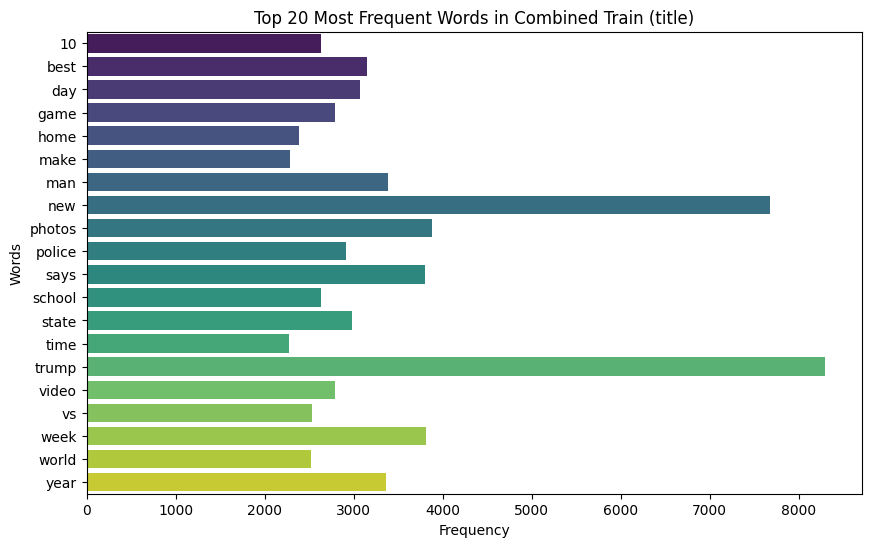

In [23]:
# Function to compute and plot top N frequent words
def plot_top_frequent_words(df, text_column, df_name, n=20):
    vectorizer = CountVectorizer(stop_words='english', max_features=n)
    X = vectorizer.fit_transform(df[text_column])
    word_counts = X.toarray().sum(axis=0)
    words = vectorizer.get_feature_names_out()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=word_counts, y=words, palette='viridis')
    plt.title(f'Top {n} Most Frequent Words in {df_name} ({text_column})')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Plot top 20 frequent words in the 'title' column
plot_top_frequent_words(combined_train_df, 'title', 'Combined Train')

#OpenAi (2024)
#GithubCoPiolet (2024)

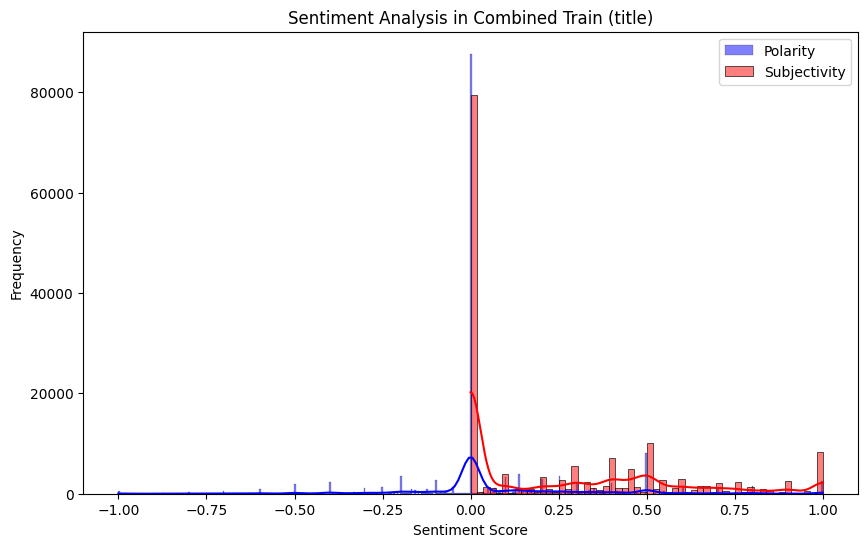

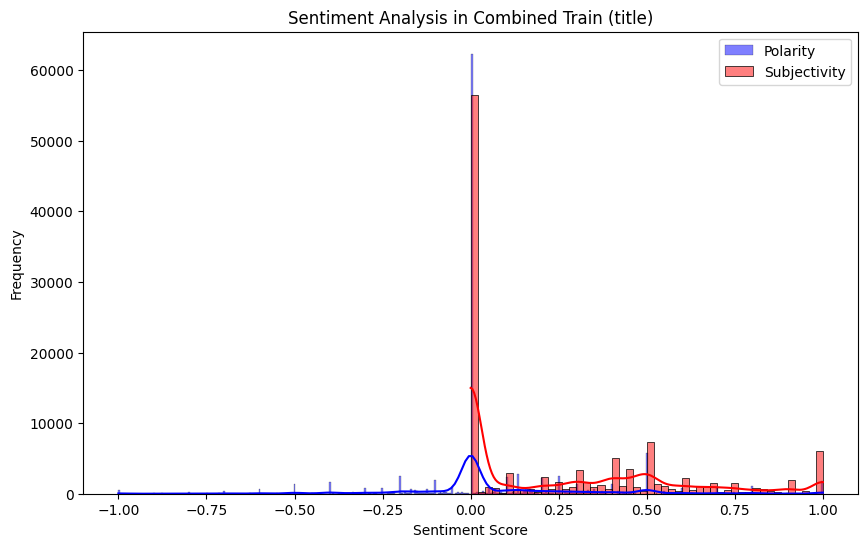

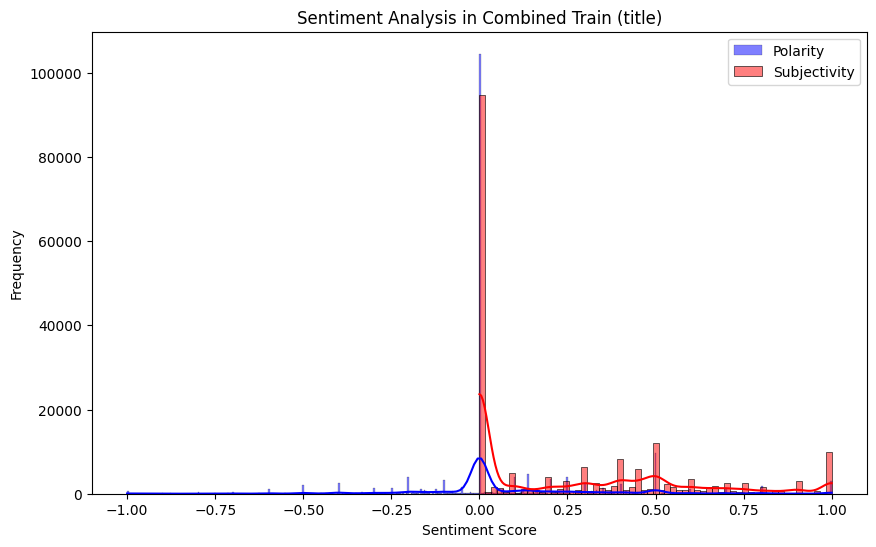

In [24]:
# Function to compute and plot sentiment analysis results
def plot_sentiment_analysis(df, text_column, df_name):
    df['polarity'] = df[text_column].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['subjectivity'] = df[text_column].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    
    # Replace infinite values with NaN and drop rows with NaN values
    df.replace([float('inf'), float('-inf')], float('nan'), inplace=True)
    df.dropna(subset=['polarity', 'subjectivity'], inplace=True)

    plt.figure(figsize=(10, 6))
    sns.histplot(df['polarity'], kde=True, color='blue', label='Polarity')
    sns.histplot(df['subjectivity'], kde=True, color='red', label='Subjectivity')
    plt.title(f'Sentiment Analysis in {df_name} ({text_column})')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Perform sentiment analysis on the 'title' column
plot_sentiment_analysis(combined_train_df, 'title', 'Combined Train')
plot_sentiment_analysis(combined_dev_df, 'title', 'Combined Train')
plot_sentiment_analysis(combined_test_df, 'title', 'Combined Train')

#OpenAi (2024)
#GithubCoPiolet (2024)

The sentiment analysis of the combined training dataset, particularly for the title column, reveals the following:

Polarity (Blue Line):

Polarity ranges from -1 (negative) to 1 (positive).
A large proportion of the titles cluster around 0 polarity, which indicates a high number of neutral news titles.
There are smaller peaks around positive values (0.5 and 1.0), indicating that some news titles are skewed towards positive sentiment.
There is minimal representation of strongly negative polarity, which suggests that very negative news titles are rare.


Subjectivity (Red Line):

Subjectivity ranges from 0 (objective) to 1 (subjective).

The majority of the titles have low subjectivity, clustering around 0. This indicates that many titles in the dataset are likely factual or objective in nature, as expected from news content.
There are visible peaks near 0.25 to 1.0, indicating some degree of subjectivity in a smaller portion of the news titles. These could be opinion pieces or editorials.
Interpretation:
Neutral Titles: The spike at 0 polarity and low subjectivity suggests that the bulk of the news titles are neutral and objective, which aligns with the nature of general news reporting.
Positive Bias: The smaller peaks at positive polarity indicate that when sentiment is expressed, it is more often positive than negative. This could be due to titles covering positive events or content like entertainment, lifestyle, or health improvements.


Actionable Insights:
If sentiment plays a role in classification, we could explore whether certain categories (e.g., entertainment, politics) exhibit different sentiment profiles.
Titles with high subjectivity or polarity could be treated differently during feature extraction, depending on the classification goals.

(TextBlob, 2023)

Now I will conduct n-gram analysis. This measures the contiguous sequence of n words. This will help to capture phrases or patterns in the dataset


C:\Users\MAMBL\AppData\Local\Temp\ipykernel_7400\2191839555.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ngram_counts, y=ngrams, palette='coolwarm')


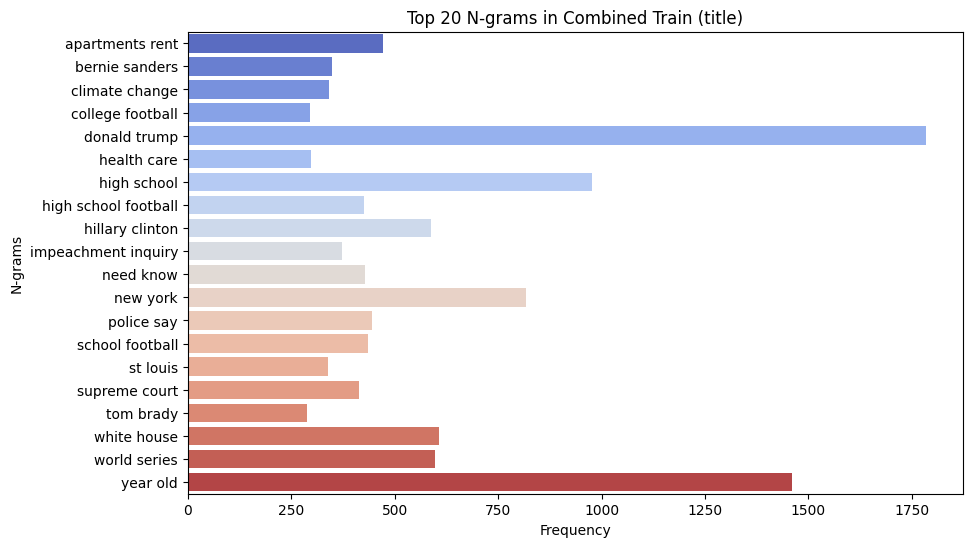

In [25]:
# Function to compute and plot top N n-grams
def plot_top_ngrams(df, text_column, df_name, n=20, ngram_range=(2, 3)): # using the range 2/3 so it does not capture any phrases that are too spesific 
    vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram_range, max_features=n)
    X = vectorizer.fit_transform(df[text_column])
    ngram_counts = X.toarray().sum(axis=0)
    ngrams = vectorizer.get_feature_names_out()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=ngram_counts, y=ngrams, palette='coolwarm')
    plt.title(f'Top {n} N-grams in {df_name} ({text_column})')
    plt.xlabel('Frequency')
    plt.ylabel('N-grams')
    plt.show()

# Plot top bigrams and trigrams in the 'title' column
plot_top_ngrams(combined_train_df, 'title', 'Combined Train')

#OpenAi (2024)
#GithubCoPiolet (2024)

# **Model Building**

I have decided to keep the polarity and objectivity data for now, as i think it will help the RNN model to learn

First I will need to initalize apache spark for processing

In [26]:
mkdir C:\tmp\spark

A subdirectory or file C:\tmp\spark already exists.


In [27]:
# Modified to_simple_rdd function to accept RDDs
def to_simple_rdd_from_rdds(sc: SparkSession, features_rdd: RDD, labels_rdd: RDD) -> RDD:
    pairs_rdd = features_rdd.zip(labels_rdd)
    return pairs_rdd

# Initilize spark and Increase driver and executor memory because the dataset is large
spark = SparkSession.builder \
    .appName("News Classification") \
    .config("spark.network.timeout", "10000s") \
    .config("spark.executor.heartbeatInterval", "200s") \
    .config("spark.rpc.message.maxSize", "1024") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.executor.memoryOverhead", "2g") \
    .config("spark.executor.instances", "4") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()
print(spark)

#(Databricks, 2023)
#OpenAi (2024)
#GithubCoPiolet (2024)

Convert pandas to spark

In [28]:
# Convert Pandas DataFrames to Spark DataFrames
train_spark_df = spark.createDataFrame(combined_train_df)
dev_spark_df = spark.createDataFrame(combined_dev_df)
test_spark_df = spark.createDataFrame(combined_test_df)

# Show the schema to verify conversion
train_spark_df.printSchema()

#OpenAi (2024)
#GithubCoPiolet (2024)

root
 |-- category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- text_length: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- subjectivity: double (nullable = true)



Tokenizer and padding using spark

In [29]:
# Fill missing title or abstract with an empty string
train_spark_df = train_spark_df.withColumn("title", when(train_spark_df.title.isNull(), "").otherwise(train_spark_df.title))
train_spark_df = train_spark_df.withColumn("abstract", when(train_spark_df.abstract.isNull(), "").otherwise(train_spark_df.abstract))

dev_spark_df = dev_spark_df.withColumn("title", when(dev_spark_df.title.isNull(), "").otherwise(dev_spark_df.title))
dev_spark_df = dev_spark_df.withColumn("abstract", when(dev_spark_df.abstract.isNull(), "").otherwise(dev_spark_df.abstract))

test_spark_df = test_spark_df.withColumn("title", when(test_spark_df.title.isNull(), "").otherwise(test_spark_df.title))
test_spark_df = test_spark_df.withColumn("abstract", when(test_spark_df.abstract.isNull(), "").otherwise(test_spark_df.abstract))

# Define a UDF for tokenizing and padding
def tokenize_pad_udf(text):
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts([text])
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=1000)
    return padded_sequence[0].tolist()

# Register the UDF with Spark
tokenize_pad_spark_udf = udf(tokenize_pad_udf, ArrayType(IntegerType()))

# Apply the UDF to Spark DataFrame
train_spark_df = train_spark_df.withColumn("padded_sequence", tokenize_pad_spark_udf(concat_ws(" ", "title", "abstract")))
dev_spark_df = dev_spark_df.withColumn("padded_sequence", tokenize_pad_spark_udf(concat_ws(" ", "title", "abstract")))
test_spark_df = test_spark_df.withColumn("padded_sequence", tokenize_pad_spark_udf(concat_ws(" ", "title", "abstract")))

#(Keras, 2023)
#OpenAi (2024)
#GithubCoPiolet (2024)


Label encoding using spark

In [30]:
# Apply StringIndexer for label encoding
indexer = StringIndexer(inputCol="category", outputCol="encoded_label")

# Fit and transform train, dev, and test datasets
indexed_train_df = indexer.fit(train_spark_df).transform(train_spark_df)
indexed_dev_df = indexer.fit(dev_spark_df).transform(dev_spark_df)
indexed_test_df = indexer.fit(test_spark_df).transform(test_spark_df)

# Show the resulting DataFrame with encoded labels
indexed_train_df.select("category", "encoded_label").show(5)
indexed_dev_df.select("category", "encoded_label").show(5)
indexed_test_df.select("category", "encoded_label").show(5)

#(Keras, 2023)
#OpenAi (2024)
#GithubCoPiolet (2024)

+---------+-------------+
| category|encoded_label|
+---------+-------------+
|lifestyle|          9.0|
|     news|          1.0|
|   health|         13.0|
|     news|          1.0|
|   health|         13.0|
+---------+-------------+
only showing top 5 rows

+---------+-------------+
| category|encoded_label|
+---------+-------------+
|lifestyle|          8.0|
|   health|         12.0|
|     news|          1.0|
|   health|         12.0|
|   health|         12.0|
+---------+-------------+
only showing top 5 rows

+---------+-------------+
| category|encoded_label|
+---------+-------------+
|lifestyle|          9.0|
|     news|          1.0|
|   health|         13.0|
|     news|          1.0|
|   health|         13.0|
+---------+-------------+
only showing top 5 rows



Convert Spark DataFrame to RDD for Elephas

In [31]:
# Convert Spark DataFrames to Pandas first and then to NumPy arrays
train_features_df = indexed_train_df.select("padded_sequence").toPandas()
train_labels_df = indexed_train_df.select("encoded_label").toPandas()

dev_features_df = indexed_dev_df.select("padded_sequence").toPandas()
dev_labels_df = indexed_dev_df.select("encoded_label").toPandas()

test_features_df = indexed_test_df.select("padded_sequence").toPandas()
test_labels_df = indexed_test_df.select("encoded_label").toPandas()

# Convert Pandas DataFrames to NumPy arrays
train_features_np = np.array(train_features_df["padded_sequence"].tolist())
train_labels_np = np.array(train_labels_df["encoded_label"].tolist())

dev_features_np = np.array(dev_features_df["padded_sequence"].tolist())
dev_labels_np = np.array(dev_labels_df["encoded_label"].tolist())

test_features_np = np.array(test_features_df["padded_sequence"].tolist())
test_labels_np = np.array(test_labels_df["encoded_label"].tolist())

# Check shapes to ensure correct conversion
print(f"Train Features Shape: {train_features_np.shape}")
print(f"Train Labels Shape: {train_labels_np.shape}")

print(f"Dev Features Shape: {dev_features_np.shape}")
print(f"Dev Labels Shape: {dev_labels_np.shape}")

print(f"Test Features Shape: {test_features_np.shape}")
print(f"Test Labels Shape: {test_labels_np.shape}")

# Define the number of classes
num_classes = len(np.unique(train_labels_np))  # This assumes labels are integers representing classes

#(Databricks, 2023)
#OpenAi (2024)
#GithubCoPiolet (2024)

Train Features Shape: (168342, 1000)
Train Labels Shape: (168342,)
Dev Features Shape: (119640, 1000)
Dev Labels Shape: (119640,)
Test Features Shape: (200313, 1000)
Test Labels Shape: (200313,)


In [32]:
# One-hot encoding the labels for multi-class classification
train_labels_one_hot = to_categorical(train_labels_np, num_classes)
dev_labels_one_hot = to_categorical(dev_labels_np, num_classes)
test_labels_one_hot = to_categorical(test_labels_np, num_classes)


Building the RNN model using Keras

In [33]:
# Define your model (RNN/LSTM)
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=1000),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # Multi-class classification requires softmax
])

# Compile the model with categorical crossentropy loss for multi-class classification
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#(Chollet, 2017)
#OpenAi (2024)
#GithubCoPiolet (2024)

Train the model

In [36]:
# Fit the model using the NumPy arrays for training and validation
history = model.fit(train_features_np, train_labels_one_hot, 
          epochs=1, batch_size=32, 
          validation_data=(dev_features_np, dev_labels_one_hot))


#(Databricks, 2023)
#OpenAi (2024)
#GithubCoPiolet (2024)

5261/5261 [==============================] - ETA: 0s - loss: 2.9286 - accuracy: 0.2193

Evaluating the model

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_features_np, test_labels_one_hot)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the trained model for future use
model.save('news_classification_model_multiclass.h5')

# Plotting Accuracy Graph
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#OpenAi (2024)
#GithubCoPiolet (2024)

Finally the code is running. I tried to get the model working with Spark and RDD but it was not working. So i eventually converted all the data back into pandas and then into Numpy arrays and the program finally runs. I decided to do only one epoch becuase the computation time was crazy. More epochs might increase the accuracy

Confusion matrix

In [ ]:
# Confusion Matrix
# Make predictions on the test set
test_predictions = np.argmax(model.predict(test_features_np), axis=1)

# Convert one-hot encoded test labels back to integers
test_labels_true = np.argmax(test_labels_one_hot, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_labels_true, test_predictions)

# Plot confusion matrix using sklearn's ConfusionMatrixDisplay
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


#(Pedregosa et al., 2011)
#OpenAi (2024)
#GithubCoPiolet (2024)

Possible improvements are using under/over fitting techniques, regularization, increasing the number of epochs and further hyper parameter turning. Due to the extreme processing power I was unable to experiment with more solutions to imporve hte accuracy.